# 知识梳理 - LSTMs
---
着重与代码实现和案例实现

内容概要
* LSTMs核心思想
* LSTMs网络训练过程
* LSTMs网络参数优化方法
* 使用LSTMs进行时间序列预测
* TensorFlow实现LSTMs（先重点讲解实现代码的API，尽可能让读者不查tf文档，读懂代码）
* 列举几个实际案例


## 1 - LSTMs 核心思想
---
LSTMs(Long Short Term Memory networks)是RNN(Recurrent Neural Network)的一个变种，它解决了RNN不能处理的长期依赖问题。对于长期依赖（long-term dependencies）的直观理解是，当前状态不仅仅是受到上一个状态的影响，而是受到前N个状态的影响。

相比于标准RNN，LSTMs在绝大多数任务上的表现都要好很多。与所有的RNN网络一样，LSTMs也具有链式结构，下图分别展现了简单RNN网络和LSTMs网络：

<img src="images/LSTM3-SimpleRNN.png" style="width:400px">
<caption><center>**1 - 标准RNN网络**</center></caption>

---
<img src="images/LSTM3-chain.png" style="width:400px">
<caption><center>**2 - LSTMs网络**</center></caption>

---
<img src="images/LSTM2-notation.png" style="width:300px">
<caption><center>**notations**</center></caption>

从上图可以清晰的看到，相比于简单RNN网络，LSTMs网络中的重复模块结构要更复杂。事实上，在LSTMs的重复模块中包含了三个门（gate）结构，分别是forget gate、input gate、output gate。门结构可以选择性的让部分信息通过，这是通过sigmoid层和一个点乘操作来实现的。这三个门结构用于保护和控制细胞状态（cell state）。

<img src="images/LSTM3-C-line.png" style="width:500px">
<caption><center>**cell state**</center></caption>
细胞状态（cell state）可以认为是LSTMs的核心思想，这个结构使得长期依赖问题得以有效解决。它就像一个传输带（conveyor belt），直接运行在整个链式结构上方，仅仅与三个门结构有一些线性交互，因此，新旧信息在cell state上传输可以做到不发生改变。

关于LSTMs的更详细介绍，请查看:[understanding LSTM networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/),中文翻译在这里:[理解LSTM网络](http://blog.csdn.net/ycheng_sjtu/article/details/48792467)



## 2 - TensorFlow中实现LSTMs
---




### module used
----
[tf.nn.dynamic_rnn](http://devdocs.io/tensorflow~python/tf/nn/dynamic_rnn)

[tf.contrib.layers.fully_connected](http://devdocs.io/tensorflow~python/tf/contrib/layers/fully_connected)

[tf.contrib.layers.optimize_loss](http://devdocs.io/tensorflow~python/tf/contrib/layers/optimize_loss)

[tf.contrib.rnn.BasicLSTMCell](http://devdocs.io/tensorflow~python/tf/contrib/rnn/basiclstmcell)

## 3 - 应用案例
---


### 3.1 - 官方案例 - PTB
TensorFlow给出的一个官方案例，在PTB(Penn Tree Bank) 数据集上训练一个LSTMs模型，目标是获得一个能确定语句概率的概率模型。为了做到这一点，通过之前已经给出的词语来预测后面的词语。

教程地址：http://www.tensorfly.cn/tfdoc/tutorials/recurrent.html 

代码地址：https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb

### 3.2 - 单变量时间序列预测
---

步骤：

1. 单变量时间序列预处理：序列平稳化、标准化等
2. 序列数据S转换成带标签的数据集D
3. 使用tensorflow构建LSTMs模型，训练、预测
4. 根据序列预处理内容，将预测结果处理成正常值



In [11]:
# 导入需要的库
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False

% matplotlib inline


从csv中读入数据，csv文件包含两列：日期和数量；使用日期列作为索引

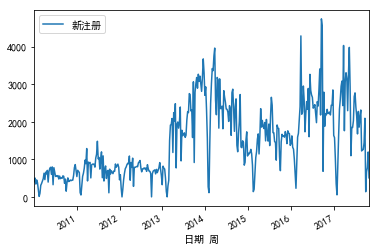

In [12]:
# 输入数据
f_csv = r"C:\DataWarehouse\sszt\2010_sszt_new.csv"
sszt_new = pd.read_csv(f_csv, index_col=[0], parse_dates=[0], encoding='gbk')
sszt_new = sszt_new.sort_index()
sszt_new.plot()

数据呈现周期性，不是稳态序列，使用差分的方法使用序列变得平稳；平稳之后的序列变化范围依然很大，使用标准化方法将序列缩放到[-1, 1]之间。

In [30]:
# 差分 & 反差分
def diffrence(seq, lag):
    "差分"
    assert isinstance(seq, pd.Series), "seq must be pd.Series, but is %s" %type(seq)
    assert isinstance(lag, int), "lag must be int, but is %s" %type(lag)
    return seq.diff(lag), lag

def inverse_diff(seq_diffed, seq, lag):
    "反差分，seq_diffed和seq的索引应当一致"
    assert isinstance(seq, pd.Series), "seq must be pd.Series, but is %s" %type(seq)
    assert isinstance(seq_diffed, pd.Series), "seq_diffed must be pd.Series, but is %s" %type(seq_diffed)
    inv_diff = seq_diffed + seq.shift(lag)
    inv_diff[0] = seq[0]
    return inv_diff

# sszt_new_diff = sszt_new['新注册'].diff(1)
# sszt_new_diff.plot()

In [ ]:
# 标准化
def scale():
    pass

def invert_scale():
    pass

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


### 单变量时间序列预测
---
总结自Jason Brownlee 的 blog - [Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)  [(中文版)](http://mp.weixin.qq.com/s/mpNtJvSQg-yIiALW_ofAEw)


使用[Shampoo Sales](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line)数据集，describes the monthly number of sales of shampoo over a 3-year period.


split the Shampoo Sales dataset into two parts: a training and a test set.

The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

执行步骤如下：

step 1. 加载数据集，并拆分成training set 和test set；

step 2. 数据集预处理，包括：Transforming the data to a supervised learning problem；Transforming the data to be stationary；Transforming the data so that it has the scale -1 to 1.

step 3. 

Fitting a stateful LSTM network model to the training data.
Evaluating the static LSTM model on the test data.
Report the performance of the forecasts.

### 使用LSTMs进行时间序列预测
---

Shampoo Sales Dataset
Test Setup
Persistence Model Forecast
LSTM Data Preparation
LSTM Model Development
LSTM Forecast
Complete LSTM Example
Develop a Robust Result
Tutorial Extensions

#### 数据划分
---
将数据划分split the Shampoo Sales dataset into two parts: a training and a test set.



### 问题排查记录
---

1. ValueError: Trying to share variable rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel, but specified shape (60, 120) and found shape (40, 120).
>解决方法 https://stackoverflow.com/questions/44615147/valueerror-trying-to-share-variable-rnn-multi-rnn-cell-cell-0-basic-lstm-cell-k

## 参考资料
---
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)  [（中文版）](http://blog.csdn.net/ycheng_sjtu/article/details/48792467)
* [LSTM与GRU的一些比较 - 论文笔记](http://blog.csdn.net/tsb831211/article/details/52136489)
* [使用MNIST数据集，在TensorFlow上实现基础LSTM网络](https://www.jiqizhixin.com/articles/2017-09-29-7)
* [How to Seed State for LSTMs for Time Series Forecasting in Python](https://machinelearningmastery.com/seed-state-lstms-time-series-forecasting-python/)
* [使用Tensorflow实现，LSTM的时间序列预测，预测正弦函数](http://www.cnblogs.com/weizhen/p/6885445.html)
* [A Critical Review of Recurrent Neural Networks for Sequence Learning](https://arxiv.org/abs/1506.00019)
* [wiki - Long short-term memory ](https://en.wikipedia.org/wiki/Long_short-term_memory)
* [A Beginner’s Guide to Recurrent Networks and LSTMs](https://deeplearning4j.org/lstm.html)